In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from esn import *
from utils import *

JAX requires the use of a PRNG (pseudo random number generator) key

In [2]:
key = jax.random.PRNGKey(1)

### Global variables

In [3]:
# for the input
T_pattern = 1500
n_pattern = 3
T = T_pattern * n_pattern
# for the ESN
dim_reservoir = 10
dim_input = 1
dim_output = 1
rho_w = 1.5
feedback = False
# for the training (& loading)
T_washout = 100
regularizer_w = 1e-3 # default: 1e-4
# for the conceptor
aperture = 10.0

### Input signal

In [4]:
dt = 0.1
ut = [
    sine(T_pattern*dt, dt, 0.6, 0.5, 1.0), # (T_pattern, 1)
    sine(T_pattern*dt, dt, 1.0, 1.0, 1.0),
    sine(T_pattern*dt, dt, 1.2, 1.8, 1.0)
]

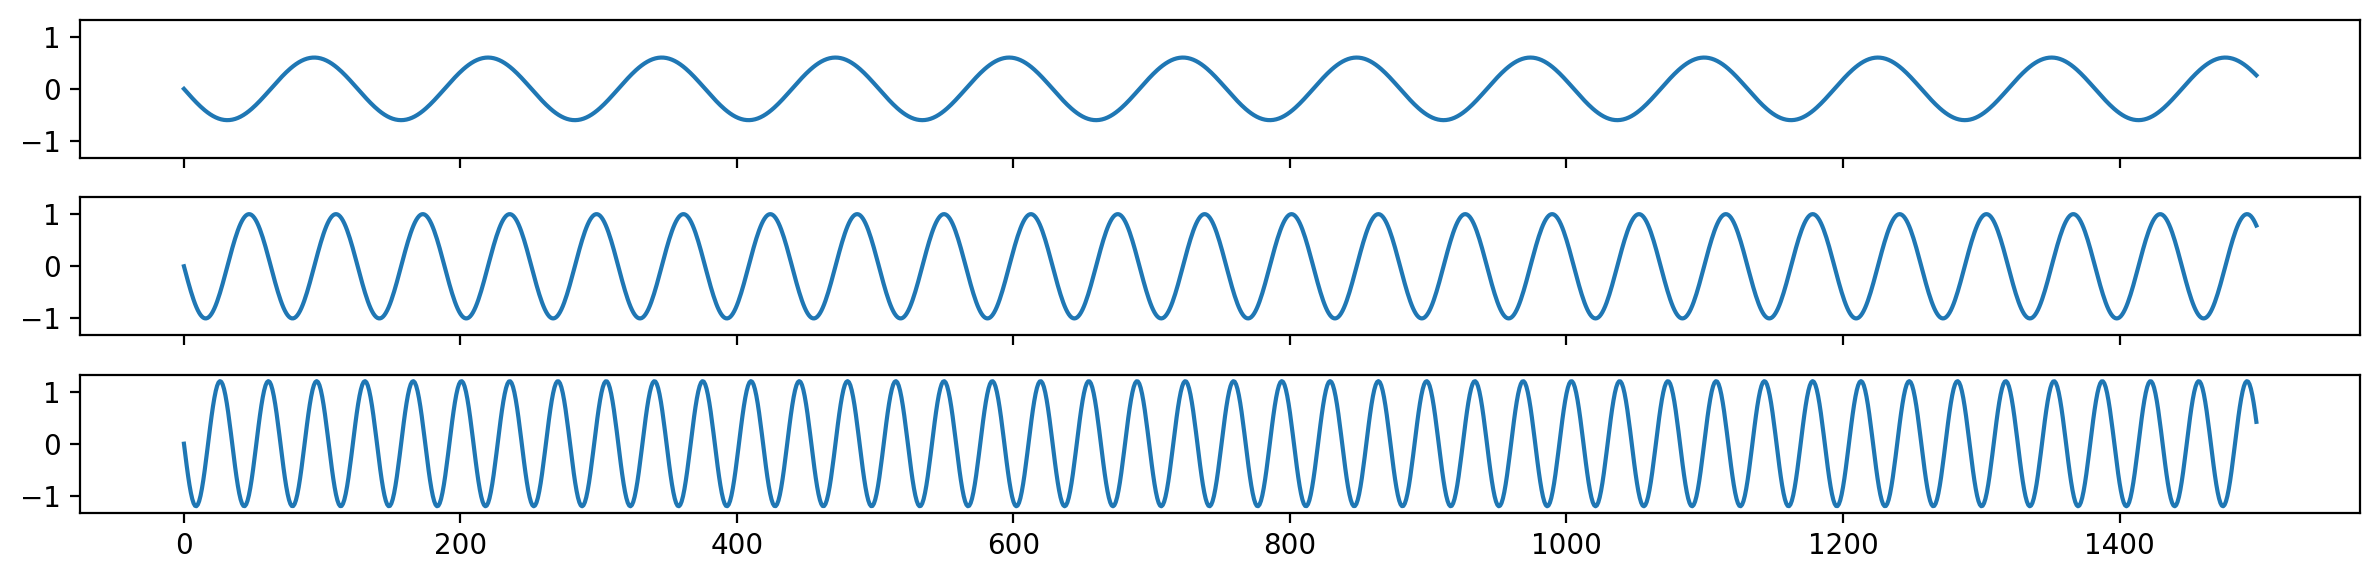

In [5]:
plot_inputs(ut)

### Create ESN

In [6]:
config = ESNConfig(
    input_size     = dim_input,
    reservoir_size = dim_reservoir,
    output_size    = dim_output,
    init_weights   = jax.random.uniform,
    rho            = rho_w, 
    feedback       = feedback
)

In [7]:
esn = ESN(key, config)

### Collect states

Feed patterns and collect states

In [8]:
# list with each of (T, *)
xt, yt = v_harvest_states(esn, ut)

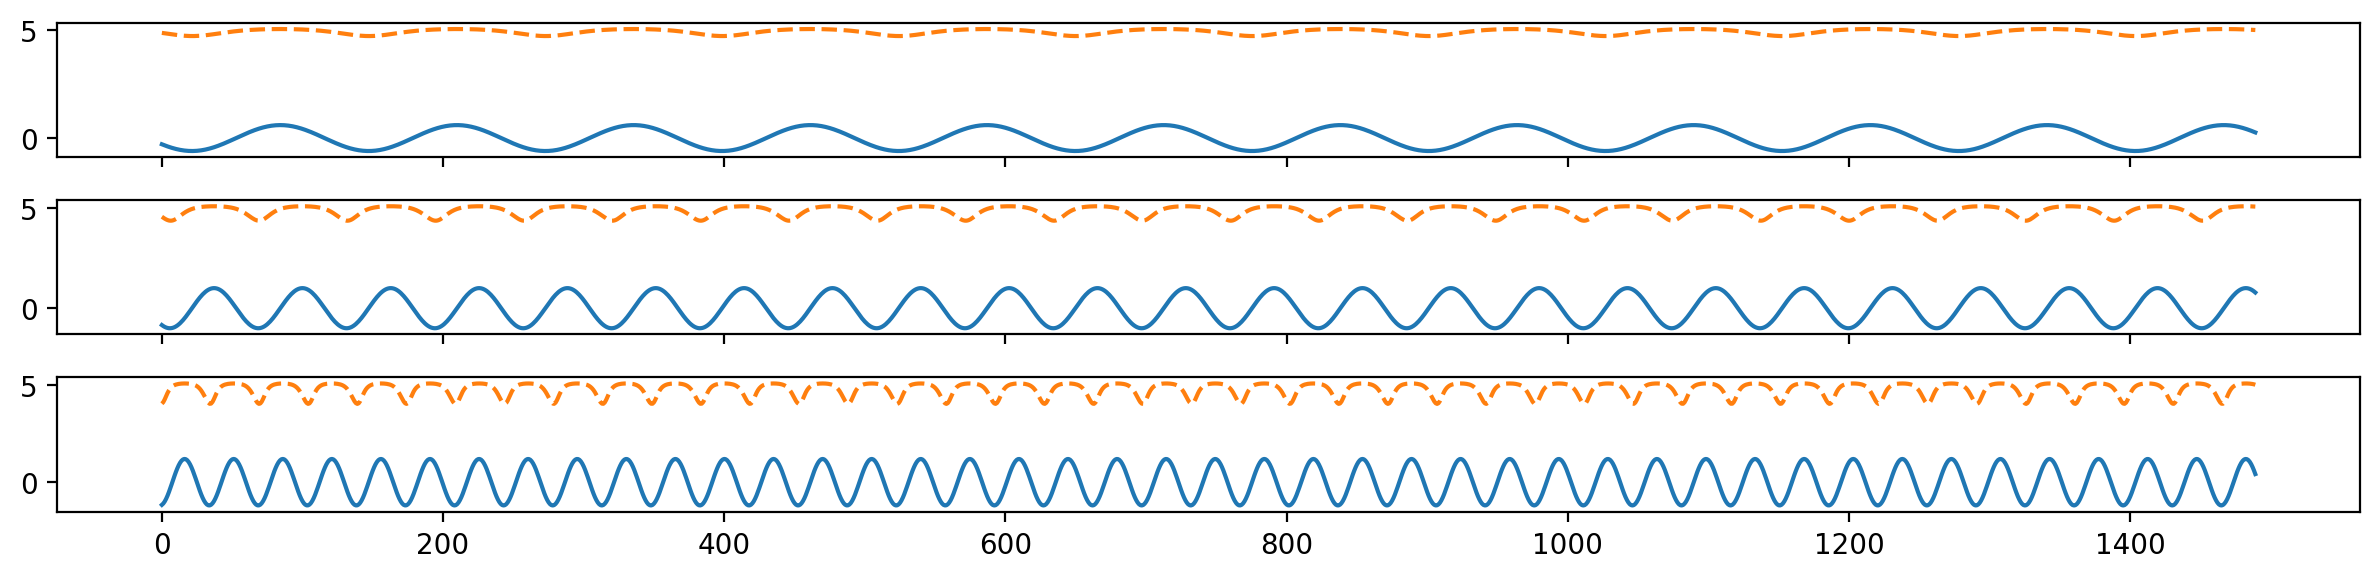

In [9]:
plot_input_output_list(ut, yt)

### Compute output weights

Make matrices: $X$ of states (with washout), $\tilde X$ of states, shifted by -1 (with washout), and $U$ of input.

In [10]:
# concatenate along time axis
X  = concatenate_patterns(xt, T_washout)
U  = concatenate_patterns(ut, T_washout)

Compute the output weights

In [11]:
opt = LinearRegression() # RidgeRegression(alpha=0.01)
esn.update_weights(X, U, U.copy(), optimizer=opt)

Feed patterns and collect states

In [12]:
xt_trained, yt_trained = v_harvest_states(esn, ut)

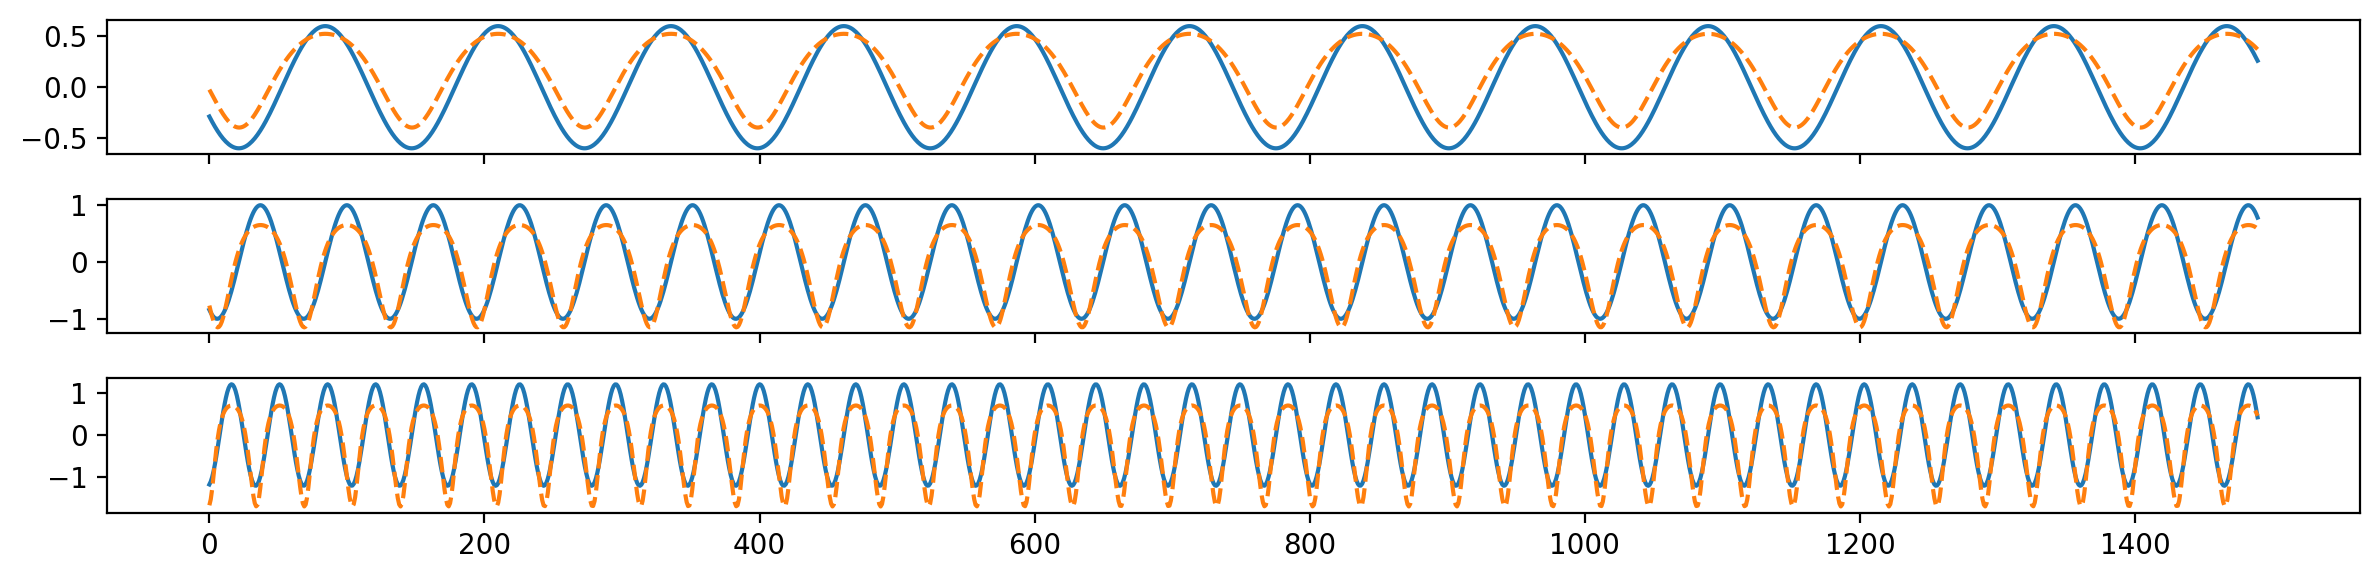

In [13]:
plot_input_output_list(ut, yt_trained)

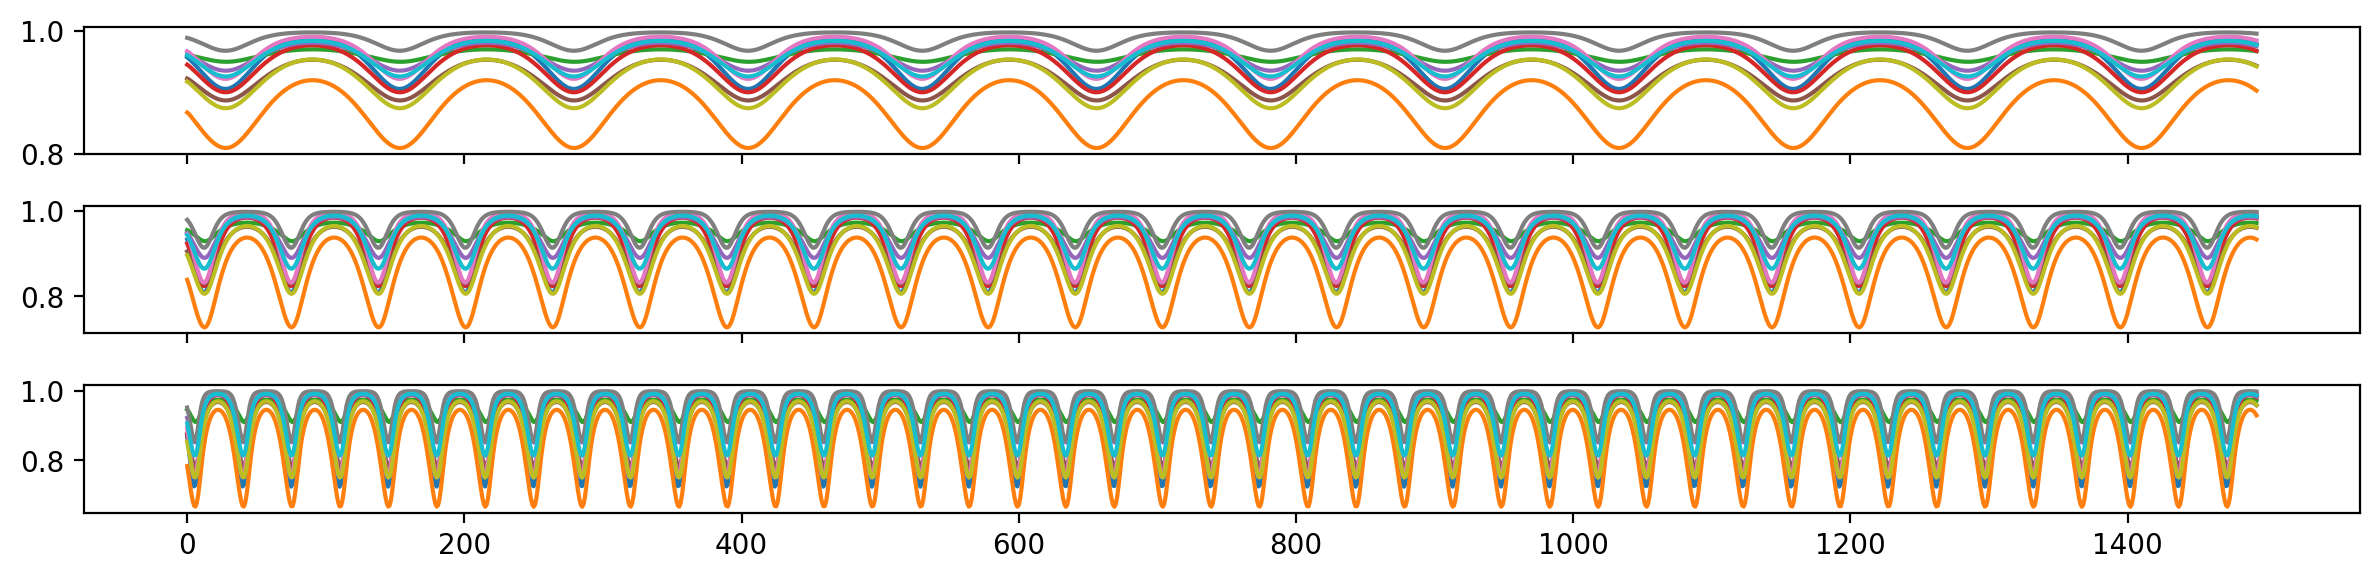

In [14]:
plot_states_list(xt_trained, washout=5, maxT=-1)

### Load reservoir

In [15]:
def loaded_reservoir(X, X_, B, N, regularizer_w):
    return jnp.dot(
        jnp.linalg.inv(jnp.dot(X_.T, X_) + regularizer_w * jnp.eye(N)),
        jnp.dot(X_.T, jnp.arctanh(X)-B)
    )

Load the reservoir by optimizing
$$
W_i = \text{argmin}_{\tilde W_i} \sum_{j=1,\ldots,K} \sum_{n=1,\ldots,L} \left[ W_i^* x^j(n) + W_i^{in} p^j (n+1) - \tilde W_i x^j(n) \right]^2
$$

where $j$ iterates over patterns and $n$ iterates over timesteps. Using ridge regression, this yields:

$$
W = \left[ (\tilde X \tilde X^T + \rho^W I)^{-1} \tilde X (\tanh^{-1}(X)-B) \right]^T
$$

where $B$ is the bias $b$, repeated over time steps.

In [16]:
# X_tilde: shifted version of state matrix X
X_ = concatenate_patterns(xt, T_washout, shift=-1)
# B: bias vector repeated over time steps
B = jnp.repeat(esn.b, X_.shape[0], axis=1).T

In [17]:
W_loaded = loaded_reservoir(X, X_, B, dim_reservoir, regularizer_w)

Load reservoir, but keep the old weight matrix saved.

In [18]:
oldW = esn.w.copy()
esn.w = W_loaded.copy()

### Test loaded reservoir without input

In [19]:
ut_loaded_zero = jnp.zeros_like(U)
xt_loaded_zero, yt_loaded_zero = esn.harvest_states(ut_loaded_zero)

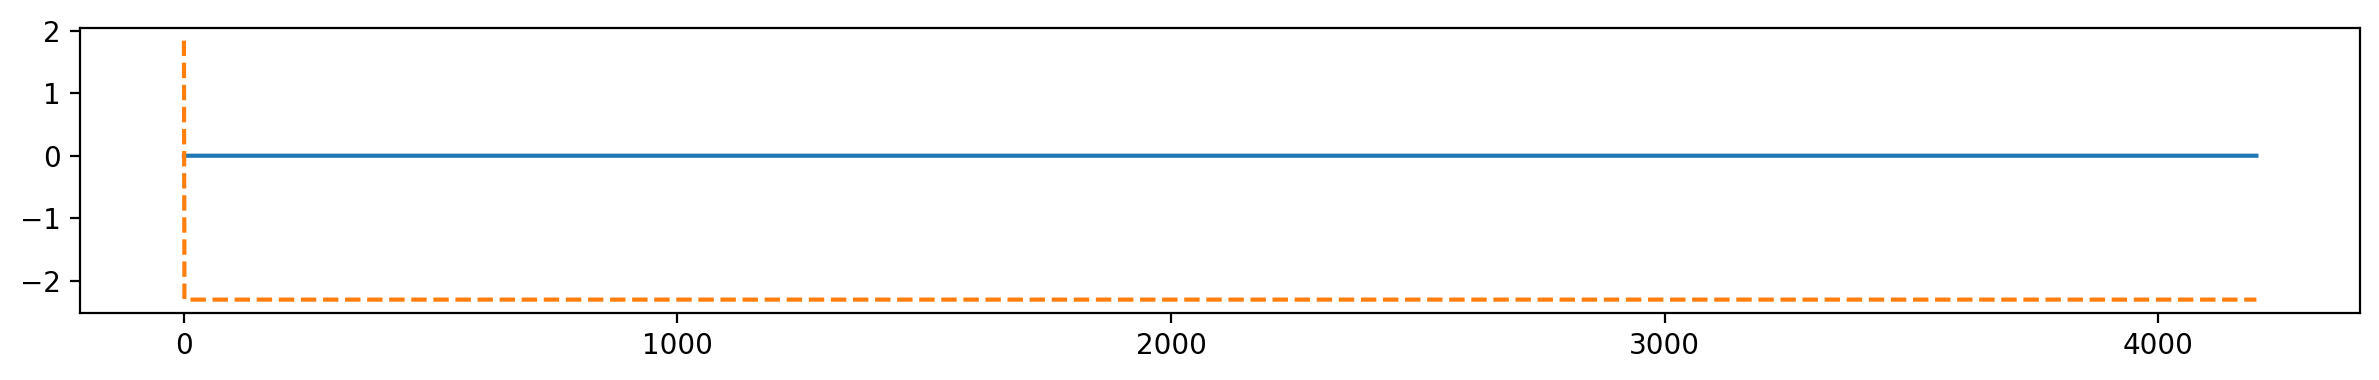

In [20]:
plot_input_output(ut_loaded_zero, yt_loaded_zero)

For reference, this is what the driven response looks like

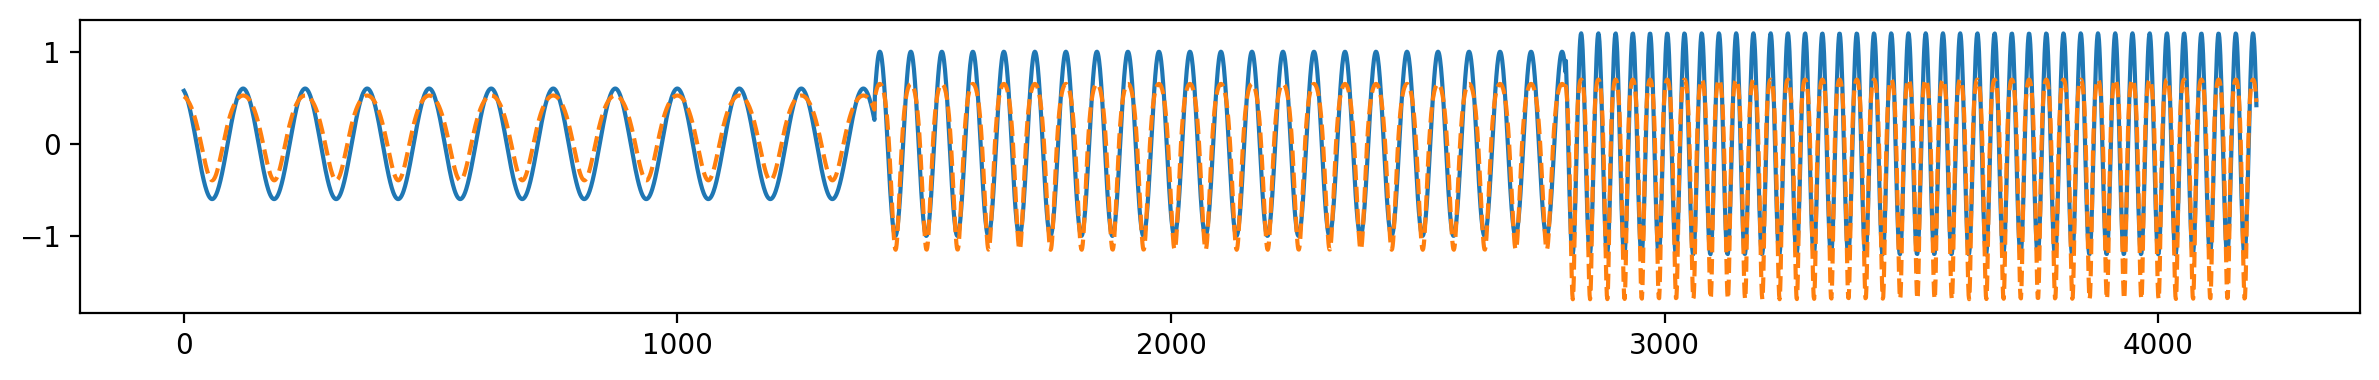

In [21]:
plot_input_output(U, concatenate_patterns(yt_trained, T_washout))

This is how the neuron activations look over time

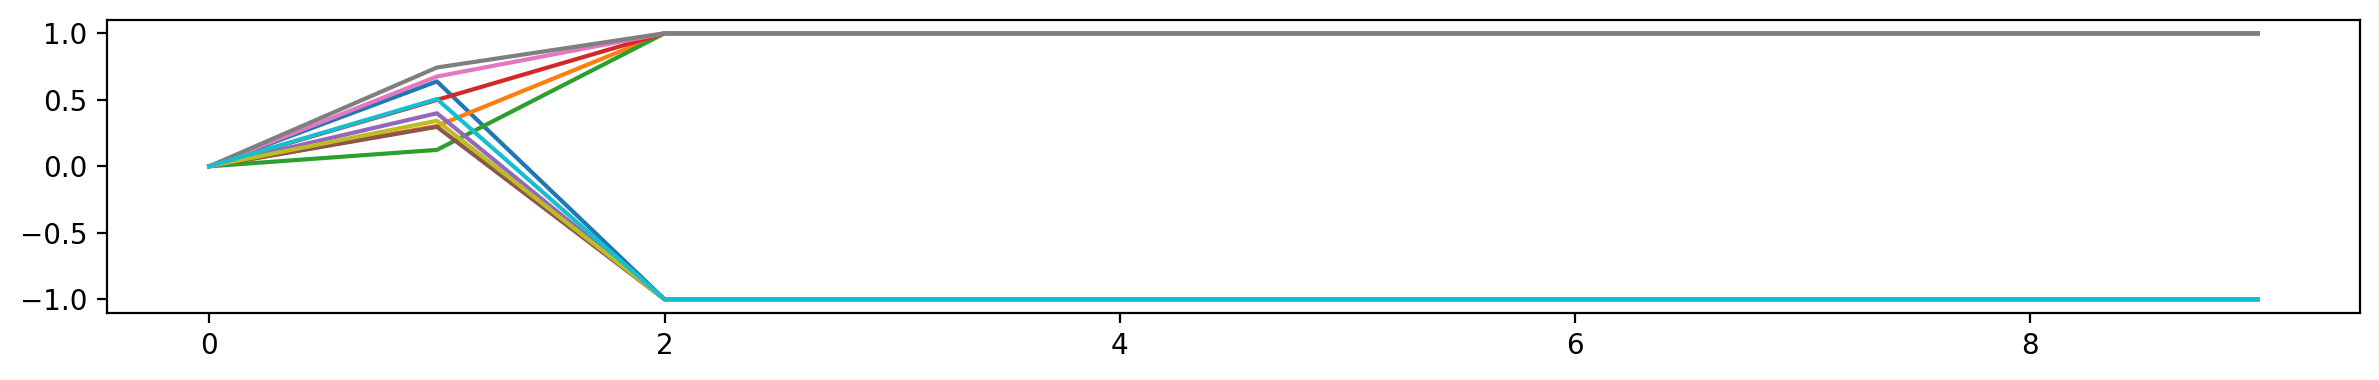

In [22]:
plot_states(xt_loaded_zero, washout=0, maxT=10)

### Compute conceptors

In [23]:
# list, for each pattern array of (T, *)
xt_loaded, yt_loaded = v_harvest_states(esn, ut)

Compute the conceptors using the correlation matrix $R$ with:
$$
C(R, \alpha) = R (R + \alpha I)^{-1}
$$

In [24]:
def compute_conceptor(X):
    R = jnp.dot(X.T, X) / X.shape[0]
    return jnp.dot(
        R, 
        jnp.linalg.inv(
            R + aperture ** (-2) * jnp.eye(R.shape[0])
        )
    )

In [25]:
Ci = [compute_conceptor(xt_loaded_i[T_washout:, :]) for xt_loaded_i in xt_loaded]

Insert conceptor into forward loop:

In [26]:
ut_zero = jnp.zeros_like(ut[0])
x_init = jax.random.uniform(key, (dim_reservoir, 1))
xt_conceptor, yt_conceptor = esn.harvest_states(ut_zero, x_init=x_init, C=Ci[1])

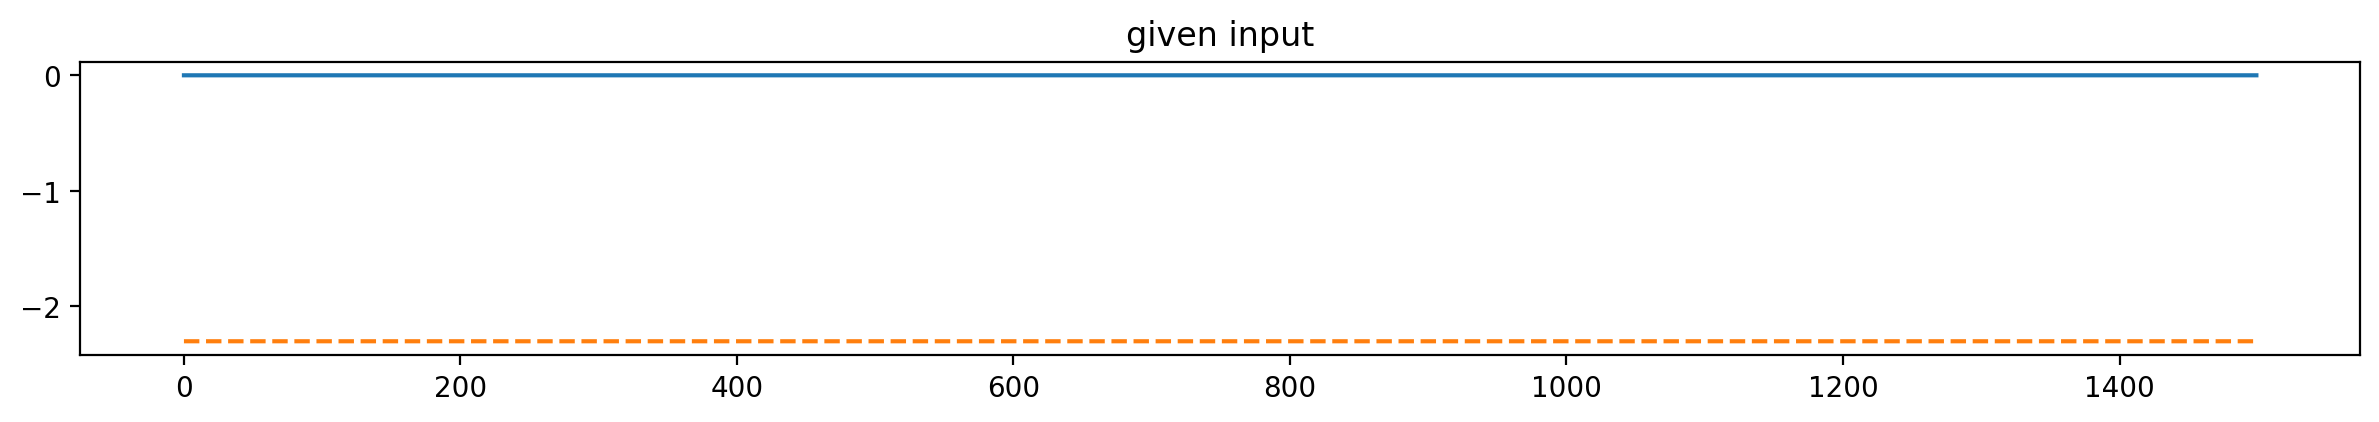

In [27]:
plot_input_output(ut_zero, yt_conceptor);plt.title('given input');

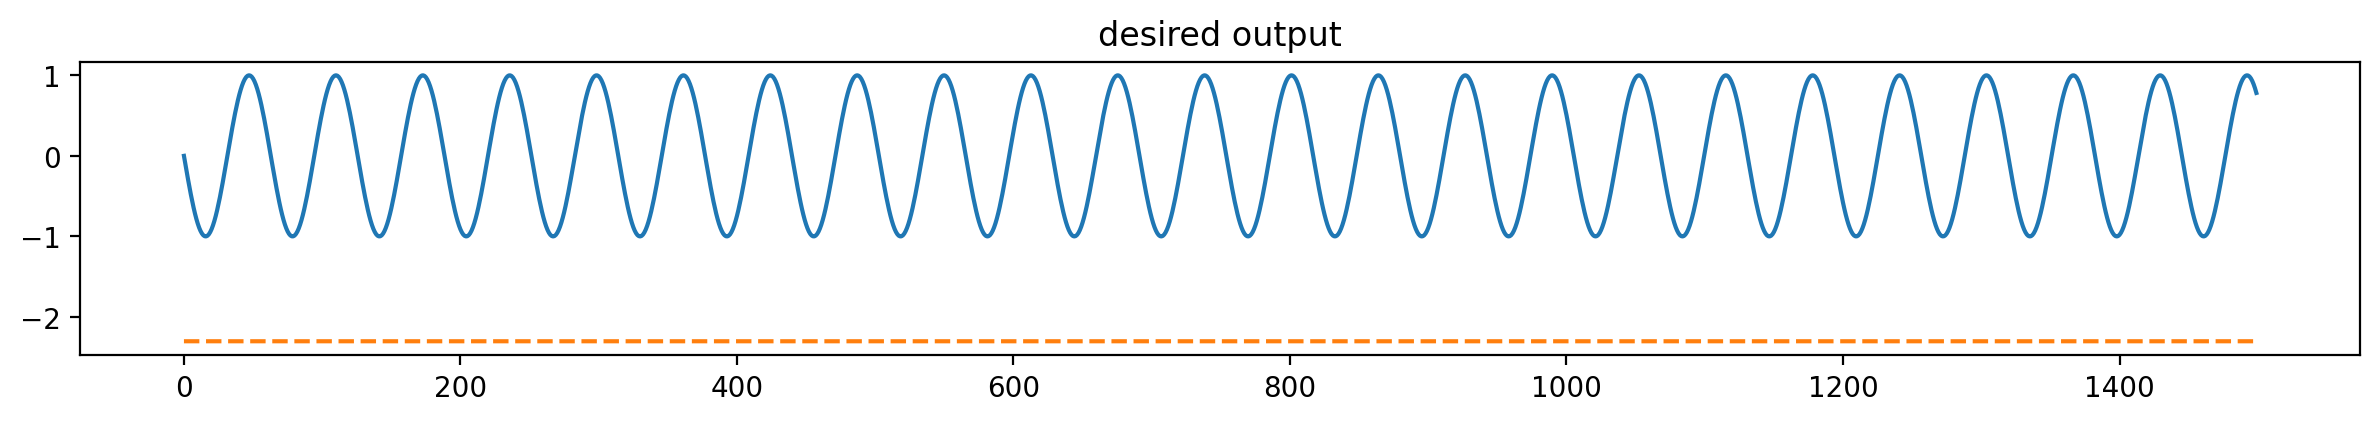

In [28]:
plot_input_output(ut[1], yt_conceptor);plt.title('desired output');